In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
import splitfolders

input_dir = '../DATA/simpsons_dataset/'
output_dir = '../DATA/data/'

splitfolders.ratio(input_dir, output=output_dir, seed=1337, ratio=(.9, .1))

Copying files: 20933 files [01:24, 246.77 files/s]


In [7]:
train_dir = '../DATA/data/train/'
val_dir = '../DATA/data/val/'

In [8]:
image_size = (64, 64, 3)
epochs = 50
batch_size = 128

labels = os.listdir(train_dir)

In [9]:
# 이미지 증식
# shear_range : 반시계 방향으로 회전
# horizontal_flip : 좌우 방향으로 뒤집기
# rotation_range : 이미지 회전값
# width_shift_range : 좌우 이동
# height_shift_range : 상하 이동

train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [10]:
# 폴더에서 이미지를 가져와 제너레이터 객체로 정의
training_set = train_datagen.flow_from_directory(train_dir,
                                                 target_size = image_size[:2],
                                                 batch_size=batch_size,
                                                 class_mode = 'sparse',
                                                 color_mode = 'rgb')

val_set = test_datagen.flow_from_directory(val_dir,
                                           target_size = image_size[:2],
                                           batch_size=batch_size,
                                           class_mode = 'sparse',
                                           color_mode = 'rgb')

Found 18820 images belonging to 43 classes.
Found 4186 images belonging to 43 classes.


In [11]:
model = Sequential()
model.add(Input(shape=image_size))
model.add(Conv2D(32, (3, 3), padding = 'same', activation = 'relu'))
model.add(Conv2D(32, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(256, (3, 3), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(1024, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(len(labels), activation = 'softmax'))

In [12]:
input_layer = Input(shape=image_size)

x1 = Conv2D(32, (3, 3), padding = 'same', activation = 'relu')(input_layer)
x2 = Conv2D(32, (3, 3), activation = 'relu')(x1)
x3 = MaxPooling2D(pool_size=(2, 2))(x2)
x4 = Dropout(0.2)(x3)
x5 = Conv2D(64, (3, 3), padding = 'same', activation = 'relu')(x4)
x6 = MaxPooling2D(pool_size=(2, 2))(x5)
x7 = Dropout(0.2)(x6)
x8 = Conv2D(256, (3, 3), padding = 'same', activation = 'relu')(x7)
x9 = MaxPooling2D(pool_size=(2, 2))(x8)
x10 = Dropout(0.2)(x9)
x11 = Flatten()(x10)
x12 = Dense(1024, activation = 'relu')(x11)
x13 = Dropout(0.5)(x12)
output_layer = Dense(len(labels), activation = 'softmax')(x13)

model = Model(inputs=input_layer, outputs = output_layer)

In [13]:
stopCB = EarlyStopping(monitor='val_acc', patience=5)

In [14]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 conv2d_5 (Conv2D)           (None, 62, 62, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 31, 31, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 31, 31, 64)        18496     
                                                             

In [16]:
stopCB = EarlyStopping(patience=5, monitor='val_acc')

checkpoint_filepath = './model.h5'
ModelCP = ModelCheckpoint(filepath=checkpoint_filepath,
                          save_weights_only = False,
                          monitor = 'val_acc',
                          mode = 'max',
                          save_best_only = True)

In [17]:
history = model.fit(training_set,
                    epochs=epochs,
                    validation_data = val_set,
                    callbacks = [stopCB, ModelCP])

Epoch 1/50
148/148 [==============================] - 237s 2s/step - loss: 2.9112 - acc: 0.1809 - val_loss: 2.3133 - val_acc: 0.3966
Epoch 2/50
148/148 [==============================] - 178s 1s/step - loss: 2.3177 - acc: 0.3635 - val_loss: 1.7069 - val_acc: 0.5409
Epoch 3/50
148/148 [==============================] - 166s 1s/step - loss: 1.9187 - acc: 0.4695 - val_loss: 1.3262 - val_acc: 0.6505
Epoch 4/50
148/148 [==============================] - 240s 2s/step - loss: 1.6537 - acc: 0.5453 - val_loss: 1.1348 - val_acc: 0.6842
Epoch 5/50
148/148 [==============================] - 147s 990ms/step - loss: 1.4168 - acc: 0.6033 - val_loss: 0.9354 - val_acc: 0.7422
Epoch 6/50
148/148 [==============================] - 162s 1s/step - loss: 1.2810 - acc: 0.6469 - val_loss: 0.7641 - val_acc: 0.7783
Epoch 7/50
148/148 [==============================] - 145s 978ms/step - loss: 1.1436 - acc: 0.6836 - val_loss: 0.6752 - val_acc: 0.8134
Epoch 8/50
148/148 [==============================] - 174s 1s/s

In [18]:
acc_loss_df = pd.DataFrame(history.history)
acc_loss_df

,loss,acc,val_loss,val_acc
0,2.911233,0.180925,2.313330,0.396560
1,2.317672,0.363496,1.706856,0.540850
2,1.918741,0.469501,1.326169,0.650502
3,1.653665,0.545324,1.134809,0.684185
4,1.416807,0.603347,0.935438,0.742236
5,1.281027,0.646918,0.764146,0.778309
6,1.143637,0.683634,0.675242,0.813426
7,1.039603,0.710202,0.621553,0.826804
8,0.999087,0.720510,0.596212,0.836359
9,0.959053,0.733581,0.526115,0.855232


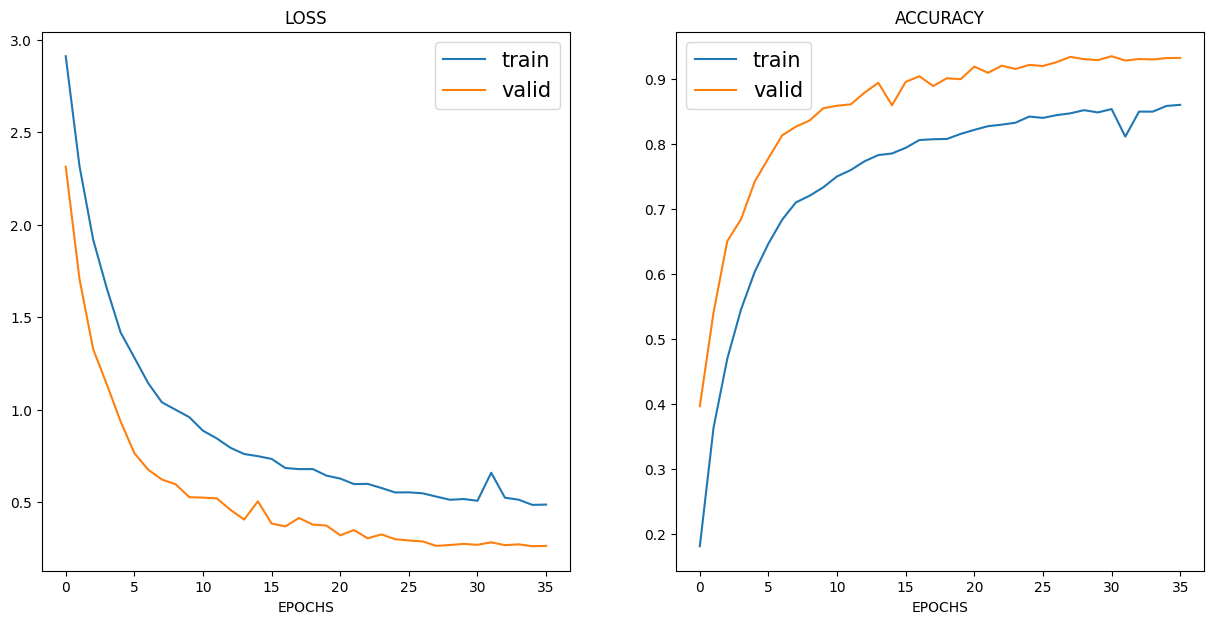

In [19]:
plt.figure(figsize=(15, 7))
plt.subplot(1,2,1)
plt.plot(acc_loss_df.iloc[:, [0, 2]])
plt.title('LOSS')
plt.xlabel('EPOCHS')
plt.legend(['train', 'valid'], fontsize=15)

plt.subplot(1,2,2)
plt.plot(acc_loss_df.iloc[:, [1, 3]])
plt.title('ACCURACY')
plt.xlabel('EPOCHS')
plt.legend(['train', 'valid'], fontsize=15)
plt.show()

In [20]:
# loading best model
saved_model = load_model('./model.h5')

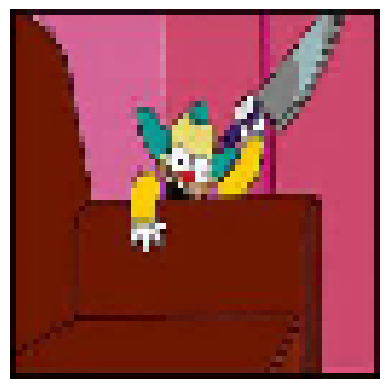

In [23]:
img_path = '../DATA/data/test/krusty_the_clown/pic_1141.jpg'
img = load_img(img_path, target_size=(64, 64, 3))
plt.imshow(img)
plt.axis('off')
plt.show()

In [24]:
def predict(img):
    img_array = img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)
    pred = saved_model.predict(img_batch)
    print(pred)
    pred = labels[np.argmax(pred)]
    return pred

In [25]:
predict(img)

1/1 [==============================] - 0s 130ms/step
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


'krusty_the_clown'